In [76]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import regex as re

from utils import *

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', 100)

In [77]:
pub_raw = pd.read_excel('../../raw_data/Bakery Orders.xlsx')

### Importing data and quick processing

In [78]:
pub_private = pub_raw[['Submitted On', 'Pick Up Date', 'Pick Up Time',
            'What would you like to order']]

In [79]:
# reset the index and copy
pub = pub_private.reset_index(drop = True).copy(deep=True)

# lower the column names
pub.columns = pub.columns.str.lower()

# remove duplicates from dataset and reset the index
pub = pub.drop_duplicates(subset='what would you like to order', keep='first')
pub = pub.reset_index(drop=True)

In [80]:
pub.head()

,submitted on,pick up date,pick up time,what would you like to order
0,2020-03-11 23:42:39,2020-03-13 00:00:00,16:30:00,1 dozen vanilla cupcakes (no sprinkle)\n1 dozen vanilla donuts (no sprinkle)
1,2020-03-29 12:59:28,2020-03-31 00:00:00,10:00:00,"Can I please order 4 pizza doughs, 2 dozen crusty rolls, 4 french sticks, 2 boston cream donuts"
2,2020-03-30 14:08:35,2020-04-01 00:00:00,09:00:00,"I would like to order 12 spinach empanadas , a dozen donuts 4 white, 4 maple and 4 boston cream,..."
3,2020-03-30 20:50:05,2020-04-03 00:00:00,11:00:00,"6 donuts - 2 Boston crème, 2 glaze, 2 vanilla sprinkle (if no Boston crème sub with chocolate di..."
4,2020-03-31 20:04:17,2020-04-03 00:00:00,13:00:00,"May I please have 4 pizza doughs, and 20 of your tim bits (the powdered ones, glazed and chocola..."


### Cleaning dates

In [81]:
# convert order dates to date times and separate by date, month, year, time
pub['submitted on']=pd.to_datetime(pub['submitted on'], dayfirst=False)

pub['order_date']=pd.to_datetime(pub['submitted on']).dt.date
pub['order_year']=pd.to_datetime(pub['submitted on']).dt.year
pub['order_month']=pd.to_datetime(pub['submitted on']).dt.month_name()
pub['order_time']=pd.to_datetime(pub['submitted on']).dt.time
pub['order_day']=pd.to_datetime(pub['submitted on']).dt.day_name()

In [82]:
# converting pick up date to time 
pub['pu_date'] = pd.to_datetime(pub['pick up date'], dayfirst=False)
pub['pu_month_name']=pd.to_datetime(pub['pu_date']).dt.month_name()
pub['pu_month']=pd.to_datetime(pub['pu_date']).dt.strftime('%m')
pub['pu_day_name']=pd.to_datetime(pub['pu_date']).dt.day_name()
pub['pu_day']=pd.to_datetime(pub['pu_date']).dt.strftime('%d')

In [83]:
# create new clean pick up dates because some were inputted wrong (e.g. before 2020)
# take year from squarespace 
pub['pu_date_clean']=pub[['order_year','pu_month','pu_day']].apply(lambda x: '-'.join(x.astype(str)), axis=1)
# conver to datetime
pub['pu_date_clean'] = pd.to_datetime(pub['pu_date_clean']).dt.date

In [84]:
# calculate days between order and pick up 
pub['order_pu_diff'] = (pub['pu_date_clean'] - pub['order_date']).dt.days

### Cleaning times

In [85]:
# change pick up time to string for cleaning
pub['pick up time'] = pub['pick up time'].astype(str)

# replace singular 0 to double 0s
pub['pick up time'] = pub['pick up time'].str.replace(r"\b(0)\b", "00", regex=True)

# convert pick up time to datetime format
pub['pu_time'] = pd.to_datetime(pub['pick up time'], infer_datetime_format=True, errors='coerce').dt.time

In [86]:
# convert remaining missings with wrong format (mixed 24H with AM/PM)
pub_na_pu_time = pub[pub['pu_time'].isna()]
# fill missing with AM/PM
pub['pu_time'] = pub['pu_time'].fillna(pd.to_datetime(pub_na_pu_time['pick up time'], format = '%H:%M:%S %p').dt.time)

In [87]:
# get pick up hour only, round to lower hour
pub['pu_hour'] = pd.to_datetime(pub['pu_time'], format='%H:%M:%S').dt.hour

In [88]:
# fix pick up hours that are inputted wrong outside of opening hours
pub['pu_hour_clean'] = pub['pu_hour'].apply(open_hour_fix)

In [89]:
# revert pick up hour back to time format
pub['pu_hour_dt'] = pd.to_datetime(pub['pu_hour_clean'], format='%H').dt.strftime('%H:%M')

### Finalizing columns for export

In [90]:
# keep: pu_date, order_year, pu_month, pu_day, pu_hour_dt
pub_clean = pub[['pu_date_clean', 'order_year', 'pu_month', 'pu_month_name', 'pu_day', 'pu_day_name', 'pu_hour_dt', 'order_pu_diff']]

In [91]:
pub_clean = pub_clean.rename(columns={
    'pu_date_clean':'pu_date', 
    'pu_month':'order_month', 
    'pu_month_name':'order_month_name', 
    'pu_hour_dt':'pu_hour'
    })

In [92]:
pub_clean.head()

,pu_date,order_year,order_month,order_month_name,pu_day,pu_day_name,pu_hour,order_pu_diff
0,2020-03-13,2020,03,March,13,Friday,16:00,2
1,2020-03-31,2020,03,March,31,Tuesday,10:00,2
2,2020-04-01,2020,04,April,01,Wednesday,09:00,2
3,2020-04-03,2020,04,April,03,Friday,11:00,4
4,2020-04-03,2020,04,April,03,Friday,13:00,3


<AxesSubplot:xlabel='count', ylabel='pu_hour'>

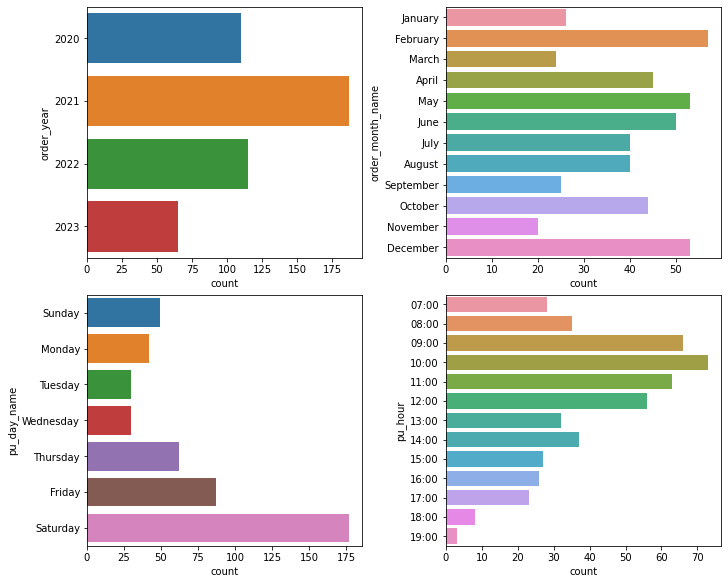

In [93]:
# exploratory plots
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

open_hours = sorted(list(pub_clean['pu_hour'].astype(str).unique()))

fig, axs = plt.subplots(2,2,figsize=(10,8), constrained_layout=True)

sns.countplot(y= pub_clean['order_year'], ax=axs[0,0])

sns.countplot(y= pub_clean['order_month_name'], order=month_order, ax=axs[0,1])

sns.countplot(y= pub_clean['pu_day_name'], order=day_order, ax=axs[1,0])

sns.countplot(y= pub_clean['pu_hour'], order=open_hours, ax=axs[1,1])

In [22]:
pub_clean.to_excel('../data/' + 'bakery_orders_clean.xlsx')

### Cleaning up orders text

In [94]:
orders = pub[['what would you like to order']]

In [95]:
orders = orders.rename(columns={'what would you like to order': 'order'})

# ensure string format
orders['order'] = orders['order'].astype(str)

In [96]:
# apply text preprocessing to remove spelling mistakes, plurals, stop words etc. 
orders['order_clean'] = orders['order'].apply(lambda x: preprocess_text(x))

In [97]:
# known bakery items
bakery_items = [
    'donut',    'ensaymada',    'empanada',
    'pandesal', 'bun',          'bread', 
    'roll',     'cookie',       'cupcake',  
    'muffin',   'biscuit',      'pineapple tart', 
    'pie',      'butter tart',  'croissant', 
    'bagel',    'asado',        'pizza',     
    'danish',   'dutchie',      'cake'
]

In [98]:
# go through orders to see any matches with known bakery items, and create a list
for idx, order in orders.iterrows():
    order = order['order_clean']
    item_matches=[]
    for item in bakery_items:
        pattern = rf"\b{item}\b"
        matches = re.search(pattern, order)
        if type(matches) != type(None):
            match_list = matches.group()
            item_matches.append(match_list)
        else:
            pass
    orders.loc[idx, 'order_list'] = ','.join(item_matches)

In [99]:
# transform to list 
orders['order_list_type'] = orders['order_list'].str.split(',')

In [100]:
# create one hot encoding for bakery items within each order
orders_ohe = orders.join(pd.DataFrame(mlb.fit_transform(orders['order_list_type']), columns=mlb.classes_, index=orders.index))

In [101]:
# join with clean data
pub_order_clean = pub_clean.join(orders_ohe[bakery_items])

In [102]:
pub_order_clean.head()

,pu_date,order_year,order_month,order_month_name,pu_day,pu_day_name,pu_hour,order_pu_diff,donut,ensaymada,...,pineapple tart,pie,butter tart,croissant,bagel,asado,pizza,danish,dutchie,cake
0,2020-03-13,2020,03,March,13,Friday,16:00,2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-31,2020,03,March,31,Tuesday,10:00,2,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2020-04-01,2020,04,April,01,Wednesday,09:00,2,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-04-03,2020,04,April,03,Friday,11:00,4,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-04-03,2020,04,April,03,Friday,13:00,3,1,0,...,0,0,0,0,0,0,1,0,0,0


In [94]:
# export final data with one hot encoded orders
pub_order_clean.to_excel("../data/" + "bakery_orders_clean.xlsx", index=0)